# Geometric Position of InSAR Points

@author: Max Felius

## Researching the Predictions
Using the 'Point Geometry Package' developed in the notebook 'Methodology_Point_Geometry'.

### Predictions
- Case 1: Less points will provide a worse fit.
- Case 2: Higher fit will be accompanied with a lower conditional number (well-conditioned vs ill-conditioned).
- Case 3: Points on a line or spread out on a 2D plane won't affect the fit and conditional number.
- Case 4: The further the points away from the center, the worse the fit will be.
- Case 5: Very heterogenous points will provide a worse fit
- Case 6: The more points with the same radius will give worse fit

In [1]:
#imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os, time
from tqdm import tqdm
import random

#import package
sys.path.extend(os.path.join(os.getcwd(),'Point_Geometry_Package'))

from Point_Geometry_Package.get_random_subsamples import get_random_subsamples
from Point_Geometry_Package.simulate_sinkhole_parameter_retrieval import simulate_sinkhole_parameter_retrieval

### Define Test Sinkhole Parameters

In [2]:
#Create cell to make point samples
#using the sinkhole from wink2016 for generating the point samples
v_wink2016_gaus = 95.78920335026163
R_wink2016_gaus = 553.0609564207195 
delta_days = np.array([0, 12, 24, 36, 48, 60, 72, 96, 108, 120, 132])

#coordinates
x0 = 25
y0 = 25

#Define the sinkhole grid
n = 100
x_range = R_wink2016_gaus
y_range = R_wink2016_gaus
x = np.linspace(x0-x_range,x0+x_range,n)
y = np.linspace(y0-y_range,y0+y_range,n)

#creat x/y grid
xv, yv = np.meshgrid(x,y)

#unravel the grids
x_unravel = xv.ravel()
y_unravel = yv.ravel()

#other parameters
max_subs = 100
n_sims = 10

### Case 1: Less Points will Provide a worse fit

In [3]:
fit_total_save, cond_number_total_save, number_subs = \
simulate_sinkhole_parameter_retrieval(delta_days,x0,y0,max_subs,n_sims,x_unravel,y_unravel,v_wink2016_gaus,R_wink2016_gaus)

Simulating:   0%|          | 0/10 [00:00<?, ?it/s]/Users/maxfelius/OneDrive/Study/Geoscience and Remote Sensing Master/year 2/Thesis/Sinkholes/Scripts/Kinematic_Model_Lagrangian/Point_Geometry/Point_Geometry_Package/case_inverse_kinematic_model.py:63: RuntimeWarning: overflow encountered in matmul
  if dx_hat.T @ Qxhat @ dx_hat < sys.float_info.epsilon:
/Users/maxfelius/OneDrive/Study/Geoscience and Remote Sensing Master/year 2/Thesis/Sinkholes/Scripts/Kinematic_Model_Lagrangian/Point_Geometry/Point_Geometry_Package/case_inverse_kinematic_model.py:63: RuntimeWarning: invalid value encountered in matmul
  if dx_hat.T @ Qxhat @ dx_hat < sys.float_info.epsilon:
/Users/maxfelius/OneDrive/Study/Geoscience and Remote Sensing Master/year 2/Thesis/Sinkholes/Scripts/Kinematic_Model_Lagrangian/Point_Geometry/Point_Geometry_Package/case_inverse_kinematic_model.py:47: RuntimeWarning: overflow encountered in double_scalars
  A2 = ((2*R**2 + 2*np.pi*r**2)/(R**3))*(v*t)*zg(R,r)
Simulating:  80%|█████

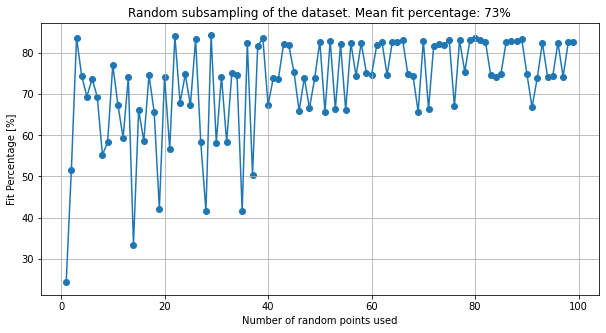

In [4]:
#extracting average fit percentages    
avg_data = np.sum(fit_total_save,axis=0)/n_sims

#Plot the results
plt.figure(figsize=(10,5))
plt.plot(number_subs,avg_data)
plt.scatter(number_subs,avg_data)

#mean of the conditional number. SKIPPED THE FIRST ENTRY
mean = np.mean(avg_data)

plt.title('Random subsampling of the dataset. Mean fit percentage: {:.0f}%'.format(mean))
plt.ylabel('Fit Percentage [%]')
plt.xlabel('Number of random points used')

plt.grid(True);

#### Conclusions
- Less number of points will provide a worse fit. The increase in points provides an increase in Fit Percentage.

### Case 2
Higher model fit will be accompanied with a lower conditional number (well-conditioned vs ill-conditioned).